# CIFAR-10 MLP

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [16]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

In [17]:
BATCH_SIZE = 32
EPOCHS = 10

In [23]:
train_dataset = datasets.CIFAR10(root = './data/CIFAR_10',
                              train = True, 
                              download = True,
                              transform = transforms.ToTensor())
test_dataset = datasets.CIFAR10(root = './data/CIFAR_10',
                              train = False, 
                              transform = transforms.ToTensor())


Extracting ./data/CIFAR_10\cifar-10-python.tar.gz to ./data/CIFAR_10


In [24]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

In [25]:
for (X_train, y_train) in train_loader:
    print(X_train.size(), X_train.type())
    print(y_train.size(), y_train.type())
    break

torch.Size([32, 3, 32, 32]) torch.FloatTensor
torch.Size([32]) torch.LongTensor


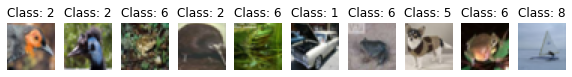

In [26]:
pltsize = 1
plt.figure(figsize = (10 * pltsize, pltsize))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i],(1,2,0)))
    plt.title('Class: ' + str(y_train[i].item()))

In [27]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
   

    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.log_softmax(x, dim = 1)
        return x

In [29]:
model = Net().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


In [30]:
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, 
                batch_idx * len(image),
                len(train_loader.dataset), 
                100. * batch_idx / len(train_loader), 
                loss.item()))

In [31]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [32]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, 
        test_loss, 
        test_accuracy))

Train Epoch: 1 [0/50000 (0%)]	Train Loss: 2.317414
Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 1.855276
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 1.919175
Train Epoch: 1 [19200/50000 (38%)]	Train Loss: 2.316419
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 1.716247
Train Epoch: 1 [32000/50000 (64%)]	Train Loss: 1.900143
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 1.510198
Train Epoch: 1 [44800/50000 (90%)]	Train Loss: 1.865025

[EPOCH: 1], 	Test Loss: 1.6943, 	Test Accuracy: 39.54 % 

Train Epoch: 2 [0/50000 (0%)]	Train Loss: 1.552614
Train Epoch: 2 [6400/50000 (13%)]	Train Loss: 1.763595
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 1.602447
Train Epoch: 2 [19200/50000 (38%)]	Train Loss: 1.781085
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 1.538527
Train Epoch: 2 [32000/50000 (64%)]	Train Loss: 1.907528
Train Epoch: 2 [38400/50000 (77%)]	Train Loss: 1.735121
Train Epoch: 2 [44800/50000 (90%)]	Train Loss: 1.534997

[EPOCH: 2], 	Test Loss: 1.6354, 	Test Accuracy: 41.61 % 

# CIFAR-10 CNN

In [46]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(
                in_channels = 3,
                out_channels = 8,
                kernel_size =3,
                padding = 1)
        self.conv2 = nn.Conv2d(
                in_channels = 8,
                out_channels = 16,
                kernel_size =3,
                padding = 1)
        self.pool = nn.MaxPool2d(
                kernel_size =2,
                stride= 2)
        self.fc1 = nn.Linear(8 * 8 * 16, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)
   

    def forward(self, x):
        x=self.conv1(x)
        x=F.relu(x)
        x=self.pool(x)
        x=self.conv2(x)
        x=F.relu(x)
        x=self.pool(x)
        
        x = x.view(-1, 8 * 8 * 16)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.log_softmax(x)
        return x

In [47]:
model = CNN().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

print(model)

CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)


In [48]:
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, 
                batch_idx * len(image),
                len(train_loader.dataset), 
                100. * batch_idx / len(train_loader), 
                loss.item()))

In [49]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [50]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, 
        test_loss, 
        test_accuracy))

C:\ProgramData\Anaconda3\envs\testAI\lib\site-packages\ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [0/50000 (0%)]	Train Loss: 2.293169
Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 1.935585
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 1.850526
Train Epoch: 1 [19200/50000 (38%)]	Train Loss: 1.516110
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 1.473519
Train Epoch: 1 [32000/50000 (64%)]	Train Loss: 1.670411
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 1.746620
Train Epoch: 1 [44800/50000 (90%)]	Train Loss: 1.481193

[EPOCH: 1], 	Test Loss: 1.4962, 	Test Accuracy: 45.76 % 

Train Epoch: 2 [0/50000 (0%)]	Train Loss: 1.290486
Train Epoch: 2 [6400/50000 (13%)]	Train Loss: 1.466208
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 1.189604
Train Epoch: 2 [19200/50000 (38%)]	Train Loss: 1.115268
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 1.287499
Train Epoch: 2 [32000/50000 (64%)]	Train Loss: 1.238660
Train Epoch: 2 [38400/50000 (77%)]	Train Loss: 1.589365
Train Epoch: 2 [44800/50000 (90%)]	Train Loss: 1.609623

[EPOCH: 2], 	Test Loss: 1.3109, 	Test Accuracy: 53.67 % 

# CIFAR-10 Augmentation

In [54]:
train_dataset = datasets.CIFAR10(root = './data/CIFAR_10',
                              train = True, 
                              download = True,
                              transform = transforms.Compose([
                                  transforms.RandomHorizontalFlip( ),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5,0.5,0.5),
                                  (0.5, 0.5, 0.5))]))
test_dataset = datasets.CIFAR10(root = './data/CIFAR_10',
                              train = False, 
                              transform = transforms.Compose([
                                  transforms.RandomHorizontalFlip(),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5,0.5,0.5),
                                  (0.5, 0.5, 0.5))]))

Files already downloaded and verified


In [55]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

In [56]:
for (X_train, y_train) in train_loader:
    print(X_train.size(), X_train.type())
    print(y_train.size(), y_train.type())
    break

torch.Size([32, 3, 32, 32]) torch.FloatTensor
torch.Size([32]) torch.LongTensor


In [60]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(
                in_channels = 3,
                out_channels = 8,
                kernel_size =3,
                padding = 1)
        self.conv2 = nn.Conv2d(
                in_channels = 8,
                out_channels = 16,
                kernel_size =3,
                padding = 1)
        self.pool = nn.MaxPool2d(
                kernel_size =2,
                stride= 2)
        self.fc1 = nn.Linear(8 * 8 * 16, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)
   

    def forward(self, x):
        x=self.conv1(x)
        x=F.relu(x)
        x=self.pool(x)
        x=self.conv2(x)
        x=F.relu(x)
        x=self.pool(x)
        
        x = x.view(-1, 8 * 8 * 16)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.log_softmax(x)
        return x

In [61]:
model = CNN().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

print(model)

CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)


In [62]:
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, 
                batch_idx * len(image),
                len(train_loader.dataset), 
                100. * batch_idx / len(train_loader), 
                loss.item()))

In [63]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [64]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, 
        test_loss, 
        test_accuracy))

C:\ProgramData\Anaconda3\envs\testAI\lib\site-packages\ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [0/50000 (0%)]	Train Loss: 2.312735
Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 1.800264
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 1.749881
Train Epoch: 1 [19200/50000 (38%)]	Train Loss: 1.794329
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 1.563488
Train Epoch: 1 [32000/50000 (64%)]	Train Loss: 1.464762
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 1.283238
Train Epoch: 1 [44800/50000 (90%)]	Train Loss: 1.422661

[EPOCH: 1], 	Test Loss: 1.3666, 	Test Accuracy: 50.99 % 

Train Epoch: 2 [0/50000 (0%)]	Train Loss: 1.165636
Train Epoch: 2 [6400/50000 (13%)]	Train Loss: 1.398453
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 1.375785
Train Epoch: 2 [19200/50000 (38%)]	Train Loss: 1.320759
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 1.426437
Train Epoch: 2 [32000/50000 (64%)]	Train Loss: 1.131732
Train Epoch: 2 [38400/50000 (77%)]	Train Loss: 1.091748
Train Epoch: 2 [44800/50000 (90%)]	Train Loss: 0.978877

[EPOCH: 2], 	Test Loss: 1.2068, 	Test Accuracy: 56.51 % 

# CIFAR-10 고급 CNN

In [91]:
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride = 1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes,
                kernel_size =3,
                stride = stride,
                padding = 1,
                bias = False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes,
                kernel_size =3,
                stride = 1,
                padding = 1,
                bias = False)
        self.bn2 = nn.BatchNorm2d(planes)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes :
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes,
                         kernel_size = 1,
                         stride= stride,
                         bias = False),
            nn.BatchNorm2d(planes))
        

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortsut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module) :
    def __init__(self, num_classes = 10):
        super(ResNet, self).__init__()
        self.in_planes = 16
    
        self.conv1=nn.Conv2d(3, 16,
            kernel_size = 3,
            stride = 1,
            padding = 1,
            bias = False)
        
        self.bn1=nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(16, 2, stride = 1)
        self.layer2 = self._make_layer(32, 2, stride = 2)
        self.layer3 = self._make_layer(64, 2, stride = 2)
        self.linear = nn.Linear(64, num_classes)
    
    def _make_layer(self, planes, num_blocks, stride) :
        strides = [stride] + [1] *(num_blocks - 1)
        layers = []
        for stride in strides :
            layers.append(BasicBlock(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forword(self, x) :
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out,size(0), -1)
        out = self.linear(out)
        return out
    
    class ResNet(nn.Module):
    def __init__(self, num_classes = 10):
        super(ResNet, self).__init__()
        self.in_planes = 16
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(16, 2, stride = 1)
        self.layer2 = self._make_layer(32, 2, stride = 2)
        self.layer3 = self._make_layer(64, 2, stride = 2)
        self.linear = nn.Linear(64, num_classes)
        
    def _make_layer(self, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks  - 1)
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [92]:
model = ResNet().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

print(model)

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=

In [93]:
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, 
                batch_idx * len(image),
                len(train_loader.dataset), 
                100. * batch_idx / len(train_loader), 
                loss.item()))

In [94]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [96]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, 
        test_loss, 
        test_accuracy))

NotImplementedError: 

In [121]:
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride = 1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size = 3, stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(planes)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size = 1, stride = stride, bias = False),
                nn.BatchNorm2d(planes))
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    
class ResNet(nn.Module):
    def __init__(self, num_classes = 10):
        super(ResNet, self).__init__()
        self.in_planes = 16
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(16, 2, stride = 1)
        self.layer2 = self._make_layer(32, 2, stride = 2)
        self.layer3 = self._make_layer(64, 2, stride = 2)
        self.linear = nn.Linear(64, num_classes)
        
    def _make_layer(self, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks  - 1)
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [122]:
model = ResNet().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

print(model)

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=

In [123]:
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))

In [124]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [125]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/50000 (0%)]	Train Loss: 2.359249
Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 1.511665
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 1.428748
Train Epoch: 1 [19200/50000 (38%)]	Train Loss: 1.177436
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 1.159982
Train Epoch: 1 [32000/50000 (64%)]	Train Loss: 1.291146
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 0.900527
Train Epoch: 1 [44800/50000 (90%)]	Train Loss: 1.207016

[EPOCH: 1], 	Test Loss: 1.3785, 	Test Accuracy: 53.96 % 

Train Epoch: 2 [0/50000 (0%)]	Train Loss: 1.098218
Train Epoch: 2 [6400/50000 (13%)]	Train Loss: 1.066333
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 0.954959
Train Epoch: 2 [19200/50000 (38%)]	Train Loss: 1.115613
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 0.732281
Train Epoch: 2 [32000/50000 (64%)]	Train Loss: 0.953931
Train Epoch: 2 [38400/50000 (77%)]	Train Loss: 1.051472
Train Epoch: 2 [44800/50000 (90%)]	Train Loss: 0.654316

[EPOCH: 2], 	Test Loss: 1.0148, 	Test Accuracy: 65.11 % 

# CIFAR - 10 딥러닝

In [149]:
import torchvision.models as models
model = models.resnet34(pretrained = False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
model = model.to(DEVICE)

In [150]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [151]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

TypeError: forward() missing 1 required positional argument: 'x'

In [152]:
model = models.resnet34(pretrained = True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
model = model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

for Epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        Epoch, test_loss, test_accuracy))

TypeError: forward() missing 1 required positional argument: 'x'

# fine-tunning

In [153]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [154]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 1.9.0  Device: cpu


In [157]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.CenterCrop(224),
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}

image_datasets = {x: datasets.ImageFolder(".downloads/archive/hymenoptera_data", data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = BATCH_SIZE, num_workers = 0, shuffle = True) for x in ['train', 'val']}

FileNotFoundError: [WinError 3] 지정된 경로를 찾을 수 없습니다: '.downloads/hymenoptera_data'

In [156]:
for (X_train, y_train) in dataloaders['train']:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

NameError: name 'dataloaders' is not defined

In [ ]:
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
    plt.title('Class: ' + str(y_train[i].item()))

In [ ]:
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))

In [ ]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [ ]:
import torchvision.models as models
model = models.resnet18(pretrained = False).cuda()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.cuda()

In [ ]:
for epoch in range(1, EPOCHS + 1):
    train(model, dataloaders["train"], optimizer, log_interval = 5)
    test_loss, test_accuracy = evaluate(model, dataloaders["val"])
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

In [ ]:
model = models.resnet18(pretrained = True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
EPOCHS = 10
for epoch in range(1, EPOCHS + 1):
    train(model, dataloaders["train"], optimizer, log_interval = 5)
    valid_loss, valid_accuracy = evaluate(model, dataloaders["val"])
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, valid_loss, valid_accuracy))